# Обучение модели классификатора 

In [87]:
import os

from ultralytics import YOLO
import cv2
from PIL import Image
import pandas as pd
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np

from utils import visualize_ba, visualize_distribution

## Загрузка датасета

In [57]:
train_df = pd.read_excel(r'train/train.xlsx')
train_df["id"] = train_df["ID"].apply(
    lambda filename: int(filename.replace("image_", "").split(".")[0])
)
train_df.drop(
    columns=[
        "Unnamed: 0.1",
        "Unnamed: 0",
        "ID",
        'annotation_path_label',
    ],
    inplace=True,
)
train_df.index = train_df["id"]

print(f'Количество исследований: {len(train_df)}')
train_df.head()

Количество исследований: 384


,image_path,pathology,id
id,,,
393,train/images/image_393.jpg,1,393
326,train/images/image_326.jpg,1,326
290,train/images/image_290.jpg,1,290
206,train/images/image_206.jpg,1,206
429,train/images/image_429.jpg,0,429


## Обрезка, сохранение новых изображений с помощью YOLO

In [58]:
model = YOLO(model='./models/best.pt')

result_list = []
count = 0
os.makedirs('train_classification/img', exist_ok=True)

for idx in train_df.index:
    try:
# for idx in [206]:
        result_bbox = model(train_df.loc[idx]['image_path'])
        for r in result_bbox:
                x = int(list(r.boxes.cuda().xywh)[0][0])
                y = int(list(r.boxes.cuda().xywh)[0][1])
                w = int(list(r.boxes.cuda().xywh)[0][2])
                h = int(list(r.boxes.cuda().xywh)[0][3])
                # Обрезаем изображение и сохраняем
                image = cv2.imread(train_df.loc[idx]['image_path'])
                crop_image = image[y:y+h, x:x+w]
                image_path = 'train_classification/img' + train_df.loc[idx]['image_path'][-14:]
                cv2.imwrite(image_path, crop_image)
                
                result_list.append([train_df.loc[idx]['id'], image_path, train_df.loc[idx]['pathology']])
    except:
        count += 1
            
print(f"{count} изображений, где не найден bbox")



image 1/1 /home/server/Documents/hack/spina_bifida/train/images/image_393.jpg: 640x256 1 ROI, 4.8ms
Speed: 0.6ms preprocess, 4.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 256)

image 1/1 /home/server/Documents/hack/spina_bifida/train/images/image_326.jpg: 640x256 1 ROI, 4.2ms
Speed: 0.7ms preprocess, 4.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 256)

image 1/1 /home/server/Documents/hack/spina_bifida/train/images/image_290.jpg: 640x224 1 ROI, 4.7ms
Speed: 0.6ms preprocess, 4.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 224)

image 1/1 /home/server/Documents/hack/spina_bifida/train/images/image_206.jpg: 640x288 1 ROI, 4.9ms
Speed: 0.8ms preprocess, 4.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /home/server/Documents/hack/spina_bifida/train/images/image_429.jpg: 640x320 2 ROIs, 5.1ms
Speed: 0.8ms preprocess, 5.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /ho

image 1/1 /home/server/Documents/hack/spina_bifida/train/images/image_310.jpg: 640x288 1 ROI, 4.7ms
Speed: 0.8ms preprocess, 4.7ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /home/server/Documents/hack/spina_bifida/train/images/image_121.jpg: 640x320 1 ROI, 5.1ms
Speed: 0.9ms preprocess, 5.1ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /home/server/Documents/hack/spina_bifida/train/images/image_256.jpg: 640x256 1 ROI, 4.5ms
Speed: 0.7ms preprocess, 4.5ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 256)

image 1/1 /home/server/Documents/hack/spina_bifida/train/images/image_292.jpg: 640x544 2 ROIs, 7.2ms
Speed: 1.1ms preprocess, 7.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 544)

image 1/1 /home/server/Documents/hack/spina_bifida/train/images/image_415.jpg: 640x640 (no detections), 7.9ms
Speed: 1.2ms preprocess, 7.9ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

imag

In [59]:
# Формирование новой таблицы с путями
classification_train_df = pd.DataFrame(result_list)
classification_train_df = classification_train_df.rename(columns={0: 'id',
                                        1: 'img_path',
                                        2: 'class'})
classification_train_df.index = classification_train_df["id"]
print(f'Количество исследований: {len(classification_train_df)}')
classification_train_df.head()

Количество исследований: 336


,id,img_path,class
id,,,
393,393,train_classification/img/image_393.jpg,1
326,326,train_classification/img/image_326.jpg,1
290,290,train_classification/img/image_290.jpg,1
206,206,train_classification/img/image_206.jpg,1
429,429,train_classification/img/image_429.jpg,0


## Балансировка датасета

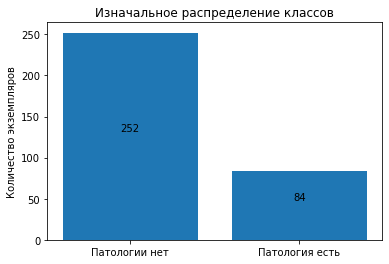

In [60]:
visualize_distribution(classification_train_df)

In [61]:
# Разделение на классы
class_0 = classification_train_df[classification_train_df['class'] == 0]
class_1 = classification_train_df[classification_train_df['class'] == 1]

# Определение большего и меньшего классов
if len(class_0) > len(class_1):
    majority_class = class_0
    minority_class = class_1
else:
    majority_class = class_1
    minority_class = class_0

In [62]:
# Целевое количество сэмплов (среднее между классами)
target_samples = int((len(majority_class) + len(minority_class)) / 2)
print(f'Целевое количество сэмплов: {target_samples}')

Целевое количество сэмплов: 168


In [63]:
# Undersampling большего класса
majority_downsampled = majority_class.sample(n=target_samples, random_state=42)

print(f'Размер после урезания большего класса: {len(majority_downsampled)}')

# Oversampling меньшего класса
minority_oversampled = minority_class.sample(replace=True, n=target_samples, random_state=14)
duplicates = minority_oversampled[minority_oversampled.duplicated()]

print(f'Размер после урезания большего класса {len(majority_downsampled)}\n',
      f'Количество дубликатов: {len(duplicates)}')

# Склейка массивов двух классов
balanced_dataset = pd.concat([minority_oversampled, majority_downsampled])
classification_train_df = balanced_dataset

Размер после урезания большего класса: 168
Размер после урезания большего класса 168
 Количество дубликатов: 98


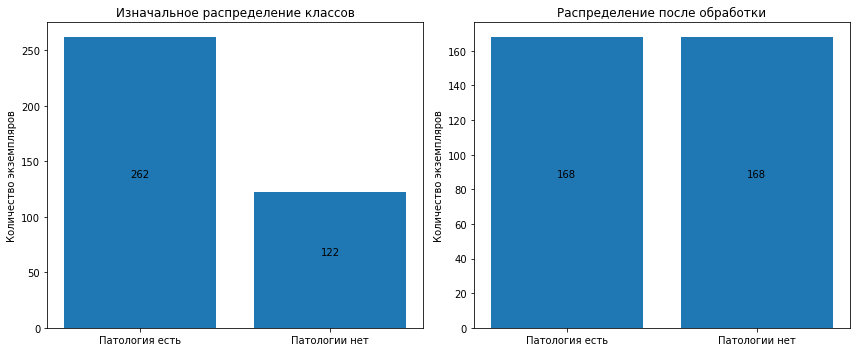

In [64]:
visualize_ba(train_df, balanced_dataset)

In [65]:
classification_train_df.head()

,id,img_path,class
id,,,
579,579,train_classification/img/image_579.jpg,0
440,440,train_classification/img/image_440.jpg,0
538,538,train_classification/img/image_538.jpg,0
496,496,train_classification/img/image_496.jpg,0
507,507,train_classification/img/image_507.jpg,0


## Инициализация класса датасета, модели и обучение

In [66]:
class SpinaBifidaDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['img_path']
        image = Image.open(img_path).convert('RGB')
        label = self.dataframe.iloc[idx]['class']

        if self.transform:
            image = self.transform(image)

        return image, label


In [67]:
# Разделение данных на обучающую и тестовую выборки
train_df = classification_train_df.sample(frac=0.8, random_state=42)
test_df = classification_train_df.drop(train_df.index)

In [68]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [69]:
# Создание датасетов
train_dataset = SpinaBifidaDataset(train_df, transform=transform)
test_dataset = SpinaBifidaDataset(test_df, transform=transform)

# Создание DataLoader'ов
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [71]:
# Загрузка предобученной модели DenseNet
model = models.densenet121(pretrained=True)

# Замена последнего слоя для двух классов
num_ftrs = model.classifier.in_features
model.classifier = torch.nn.Linear(num_ftrs, 2)

# Перемещение модели на GPU, если доступно
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определение функции потерь и оптимизатора
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/home/server/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/server/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [78]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/10, Loss: 0.2276
Epoch 2/10, Loss: 0.2842
Epoch 3/10, Loss: 0.1495
Epoch 4/10, Loss: 0.1787
Epoch 5/10, Loss: 0.1070
Epoch 6/10, Loss: 0.0455
Epoch 7/10, Loss: 0.0191
Epoch 8/10, Loss: 0.0093
Epoch 9/10, Loss: 0.0092
Epoch 10/10, Loss: 0.0087


In [79]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 81.40%


## Вычисляем метрики

In [81]:
def calculate_metrics(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    dice = 2 * tp / (2 * tp + fp + fn)
    
    fpr, tpr, _ = roc_curve(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_preds)
    
    return cm, dice, fpr, tpr, roc_auc

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(cm):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Class 0', 'Class 1'])
    plt.yticks(tick_marks, ['Class 0', 'Class 1'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2 else "black")
    
    plt.tight_layout()
    plt.show()

DICE Score: 0.8889
ROC AUC: 0.6824


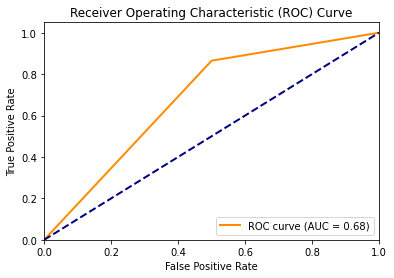

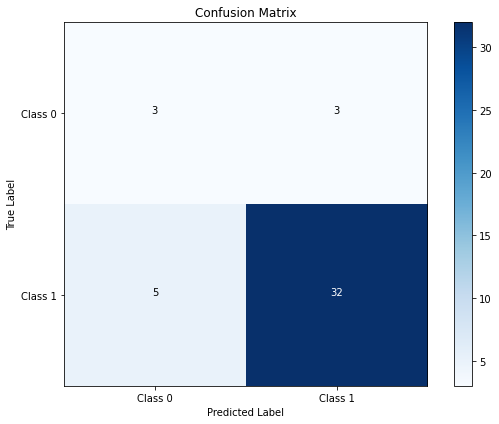

In [82]:
cm, dice, fpr, tpr, roc_auc = calculate_metrics(model, test_loader)

print(f"DICE Score: {dice:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

plot_roc_curve(fpr, tpr, roc_auc)
plot_confusion_matrix(cm)

In [83]:
torch.save(model.state_dict(), 'models/densenet_weights.pth')

In [89]:
# функция для загрузки модели
def load_model(model_path):
    model = models.densenet121(pretrained=False)
    num_ftrs = model.classifier.in_features
    model.classifier = torch.nn.Linear(num_ftrs, 2)
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()
    return model

In [90]:
# функция для предсказания для одного изображения
def predict_single_image(model, image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    
    return predicted.item(), probabilities[0].cpu().numpy()

In [91]:
# функция для тестирования на наборе данных из csv
def predict_from_csv(model, csv_path):
    df = pd.read_csv(csv_path)
    predictions = []
    true_labels = []
    
    for _, row in df.iterrows():
        img_path = row['img_path']
        true_label = row['class']
        
        predicted_class, probabilities = predict_single_image(model, img_path)
        predictions.append(predicted_class)
        true_labels.append(true_label)
        
        print(f"Image: {img_path}")
        print(f"True class: {true_label}")
        print(f"Predicted class: {predicted_class}")
        print(f"Probabilities: Class 0 - {probabilities[0]:.4f}, Class 1 - {probabilities[1]:.4f}")
        print("---")
    
    accuracy = sum(1 for x, y in zip(predictions, true_labels) if x == y) / len(predictions)
    print(f"Overall accuracy: {accuracy:.4f}")
    
    return predictions, true_labels

In [100]:
test_df.to_csv('test_data.csv')

In [99]:
test_df['img_path'][416]

'train_classification/img/image_416.jpg'

/home/server/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/server/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted class for single image: 0
Probabilities: Class 0 - 0.7858, Class 1 - 0.2142
Image: train_classification/img/image_440.jpg
True class: 0
Predicted class: 0
Probabilities: Class 0 - 0.6139, Class 1 - 0.3861
---
Image: train_classification/img/image_416.jpg
True class: 0
Predicted class: 0
Probabilities: Class 0 - 0.7858, Class 1 - 0.2142
---
Image: train_classification/img/image_493.jpg
True class: 0
Predicted class: 1
Probabilities: Class 0 - 0.0126, Class 1 - 0.9874
---
Image: train_classification/img/image_440.jpg
True class: 0
Predicted class: 0
Probabilities: Class 0 - 0.6139, Class 1 - 0.3861
---
Image: train_classification/img/image_449.jpg
True class: 0
Predicted class: 1
Probabilities: Class 0 - 0.0045, Class 1 - 0.9955
---
Image: train_classification/img/image_479.jpg
True class: 0
Predicted class: 1
Probabilities: Class 0 - 0.0240, Class 1 - 0.9760
---
Image: train_classification/img/image_469.jpg
True class: 1
Predicted class: 1
Probabilities: Class 0 - 0.0022, Clas

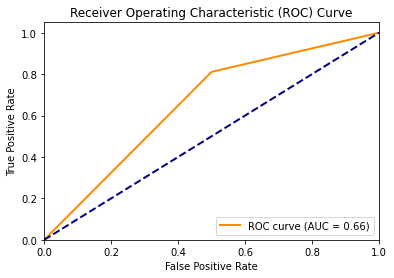

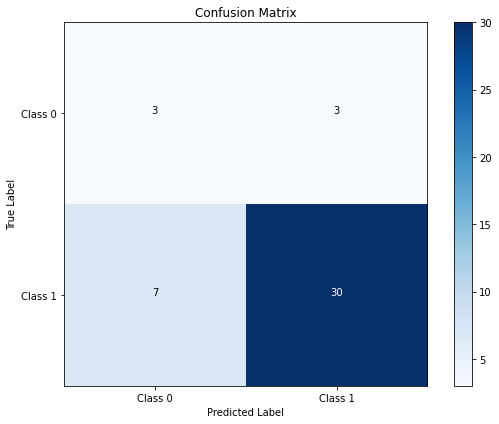

In [101]:
# Загрузка модели
loaded_model = load_model('models/densenet_weights.pth')

# Предсказание для одного изображения
single_image_path = test_df['img_path'][416]
predicted_class, probabilities = predict_single_image(loaded_model, single_image_path)
print(f"Predicted class for single image: {predicted_class}")
print(f"Probabilities: Class 0 - {probabilities[0]:.4f}, Class 1 - {probabilities[1]:.4f}")

# Предсказание для набора изображений из CSV файла
csv_path = 'test_data.csv'
predictions, true_labels = predict_from_csv(loaded_model, csv_path)

# Расчет и вывод метрик
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(cm)

accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy:.4f}")

roc_auc = roc_auc_score(true_labels, predictions)
print(f"ROC AUC: {roc_auc:.4f}")

tn, fp, fn, tp = cm.ravel()
dice = 2 * tp / (2 * tp + fp + fn)
print(f"DICE Score: {dice:.4f}")

# Построение ROC-кривой
fpr, tpr, _ = roc_curve(true_labels, predictions)
plot_roc_curve(fpr, tpr, roc_auc)

# Отображение confusion matrix
plot_confusion_matrix(cm)